In [11]:
from lib.Base64 import path_to_base64
from skimage import io
import numpy as np
#from PIL import Image
import cv2
import mediapipe as mp
#from segment_anything 
from lib.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os
import json
import matplotlib.pyplot as plt
import sys



sys.path.append("..")
sam_checkpoint = f"{os.path.abspath(os.getcwd())}/lib/sam_vit_h_4b8939.pth"
model_type = "default"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(
    #device='mps'
    )

predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=None,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=20,
    point_grids=[[[0.5,0.5]],[[0.4,0.5]],[[0.6,0.5]]])

In [27]:



class SMILE:
    def __init__(self,input_path,out_dir):
        self.input_path=input_path 
        self.out_dir=out_dir


        img=io.imread(input_path)
        h, w ,d= img.shape
        self.img=cv2.resize(img, (512, int(512*h/w)), interpolation=cv2.INTER_AREA)
        self.img=cv2.cvtColor(self.img,cv2.COLOR_RGB2BGR)
        self.shape=self.img.shape

        self.mouse=[]
        self.box=[]
        self.boximg=[]

        
        
        self.cuted=[]
        self.mask={}
        self.out_path=out_dir
        self.base64=''

        pass
    def set_predictor(self):
        try:
            self.box[1]
        except:
            self.find_mouse()
        predictor.set_image(self.boximg)
    
    def predict(self, point):
        masks, scores, logits = predictor.predict(
        point_coords=point,
        point_labels=np.array([1]*len(point)),
        multimask_output=True,
        )
        return masks, scores, logits
        

    def gen_mask(self):
        try:
            self.box[1]
        except:
            self.find_mouse()
        
        self.masks = mask_generator.generate(self.img[self.box[2]-5:self.box[3]+5,self.box[0]-5:self.box[1]+5])
        self.masks  = sorted(self.masks , key=(lambda x: x['area']), reverse=True)



        
        

    def cut(self, pol):
        pol=np.array([pol], np.int32)
        #遮片
        mask=np.zeros(self.img.shape[:2], np.uint8)
        #多邊形填上白色
        cv2.polylines(mask, [pol], isClosed=True,color=(255,255,255), thickness=1)
        cv2.fillPoly(mask,pol,255)
        
        dst=cv2.bitwise_and(self.img, self.img, mask=mask)
        return dst
    
    def find_mouse(self):
        h, w, d = self.img.shape
        mp_face_detection = mp.solutions.face_detection
        mp_face_mesh = mp.solutions.face_mesh
        face_mesh=mp_face_mesh.FaceMesh(
            min_detection_confidence=0.2,
            min_tracking_confidence=0.2)
    #嘴巴
        mouse=[62,96,89,179,86,15,316,403,319,325,292,407,272,271,268,12,38,41,42,183]
        lip=[78,95,88,178,87,14,317,402,318,324,308,415,310,311,312,13,82,81,80,191]#嘴唇
    
        #########################openCV辨識嘴 #########################
        RGBim = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(RGBim)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                #for index in mouse:
                for index in lip:
                    x = int(face_landmarks.landmark[index].x * w)
                    y = int(face_landmarks.landmark[index].y * h)
                    self.mouse.append([x,y])
        self.mouse=np.array(self.mouse)
        
        """mousep_b=[]
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for index in mouse:
                    x = int(face_landmarks.landmark[index].x * w)
                    y = int(face_landmarks.landmark[index].y * h)
                    mousep_b.append([x,y])
        mousep_b=np.array(mousep_b)"""

        
        #找 marker
        umos=min(self.mouse[:,1])#嘴上緣
        dmos=max(self.mouse[:,1])#嘴下緣
        lmos=min(self.mouse[:,0])#嘴左緣
        rmos=max(self.mouse[:,0])#嘴右緣
        wmos=rmos-lmos#嘴寬
        hmos=dmos-umos#嘴高
        mmos=[int((lmos+rmos)/2),int((umos+dmos)/2)]#嘴中心

        self.box=np.array([lmos,rmos,umos,dmos])
        self.boximg=self.img[self.box[2]-5:self.box[3]+5,self.box[0]-5:self.box[1]+5]

        
        
        
        ##self.cuted=self.cut( self.mouse)
        
        return self.box
    def show_box(self):
        path=f"{self.out_dir}/{self.input_path.split('/')[-1]}"

        cv2.imwrite(path
                    ,self.img[self.box[2]-20:self.box[3]+20,self.box[0]-20:self.box[1]+20])
        return path_to_base64(path)


    


        


    


    def show_anns(self):
        import matplotlib.pyplot as plt

        if len(self.masks) == 0:
            return

        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        color = []
        figsize=self.box[1]-self.box[0]
        for ann in self.mask:
            #print(ann)
            if (ann['area']>figsize/10) ^ (ann['area']<figsize/200):
                continue

            
            m = ann['segmentation']
            img = np.ones((m.shape[0], m.shape[1], 3))
            color_mask = np.random.random((1, 3)).tolist()[0]
            for i in range(3):
                img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, m*0.35)))
        plt.axis('off')

        #path=f"ooouuuttt{self.input_path.split('.')[-1]}"
        #plt.savefig(path)
        #return path_to_base64(path)
        plt.show()
    def show_points(coords, labels, ax, marker_size=375):
        pos_points = coords[labels==1]
        neg_points = coords[labels==0]
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    def show_mask(mask, ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)




def SMILE_0(path):
    ########圖像處理########
    def cut(img, pol):
        pol=np.array([pol], np.int32)
        #遮片
        mask=np.zeros(img.shape[:2], np.uint8)
        #多邊形填上白色
        cv2.polylines(mask, [pol], isClosed=True,color=(255,255,255), thickness=1)
        cv2.fillPoly(mask,pol,255)
        
        dst=cv2.bitwise_and(img, img, mask=mask)
        return dst


    img=io.imread(path)
    h, w ,d= img.shape
    img=cv2.resize(img, (1000, int(1000*h/w)), interpolation=cv2.INTER_AREA)
    pol=np.array([[110,200],[300,400],[160,50]])
    #pol= np.array([[200, 200], [300, 100], [300, 200], [200, 200], [200, 250]], np.int32)
    img=cut(img,pol)



    result = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #######輸出#####
    out_path='output.jpg'
    cv2.imwrite(out_path, img)
    
    
    
    return path_to_base64(out_path)
    #return 'a'    
    


In [33]:

filename = "upload_fig/{}.{}".format('input', 'png')

nowfig=SMILE(filename,'output' )
nowfig.find_mouse()
nowfig.set_predictor()
#nowfig.predict()

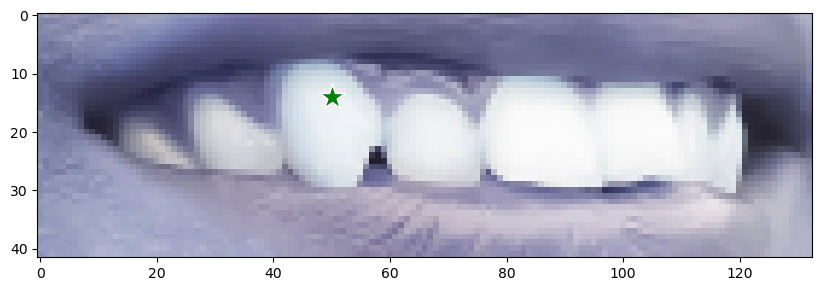

In [34]:
input_point=np.array([[50, 14]])
input_label=np.array([1])
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

plt.figure(figsize=(10,10))
plt.imshow(nowfig.boximg)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

In [35]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

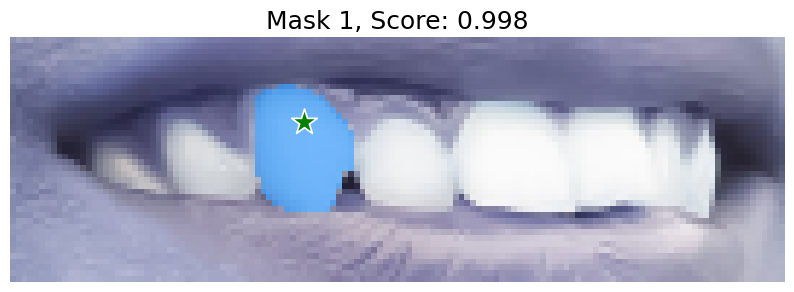

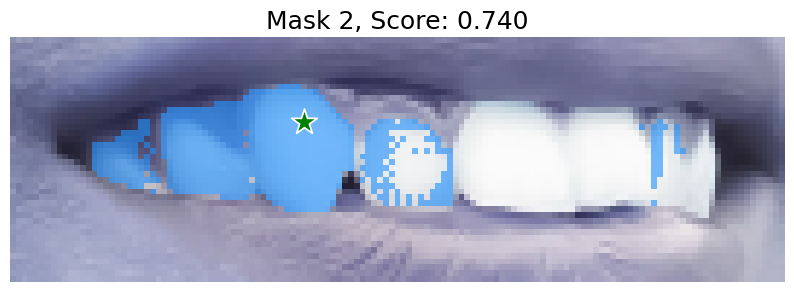

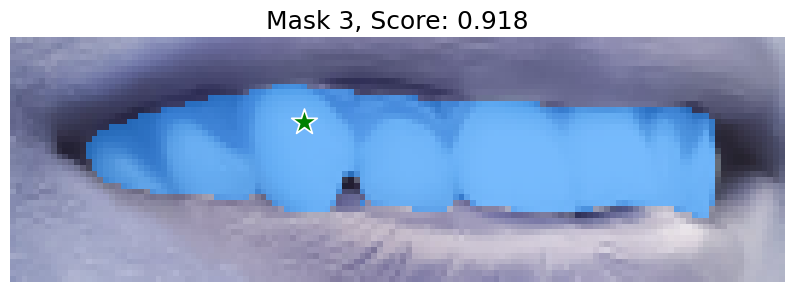

In [41]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(nowfig.boximg)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    show_points(point,[1]*len(point), plt.gca())
    plt.axis('off')
    plt.show()  

In [43]:
np.array([1]*9
         )

array([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [46]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

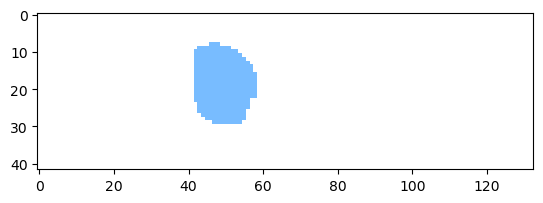

In [47]:
arr=list(zip(masks, scores))
sorted_arr = sorted(arr, key=(lambda x: x[1]), reverse=True)
show_mask(sorted_arr[0][0], plt.gca())

In [16]:

from typing import Any, Dict, Generator, ItemsView, List, Tuple

def build_point_grid(n_per_side: int) -> np.ndarray:
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * n_per_side)
    points_one_side = np.linspace(offset, 1 - offset, n_per_side)
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points
def build_all_layer_point_grids(
    n_per_side: int, n_layers: int, scale_per_layer: int
) -> List[np.ndarray]:
    """Generates point grids for all crop layers."""
    points_by_layer = []
    for i in range(n_layers + 1):
        n_points = int(n_per_side / (scale_per_layer**i))
        points_by_layer.append(build_point_grid(n_points))
    return points_by_layer

In [29]:
a=build_all_layer_point_grids(
                30,
                0,
                2,
            )
np.array(a)
a[0][200:230]

array([[0.68333333, 0.21666667],
       [0.71666667, 0.21666667],
       [0.75      , 0.21666667],
       [0.78333333, 0.21666667],
       [0.81666667, 0.21666667],
       [0.85      , 0.21666667],
       [0.88333333, 0.21666667],
       [0.91666667, 0.21666667],
       [0.95      , 0.21666667],
       [0.98333333, 0.21666667],
       [0.01666667, 0.25      ],
       [0.05      , 0.25      ],
       [0.08333333, 0.25      ],
       [0.11666667, 0.25      ],
       [0.15      , 0.25      ],
       [0.18333333, 0.25      ],
       [0.21666667, 0.25      ],
       [0.25      , 0.25      ],
       [0.28333333, 0.25      ],
       [0.31666667, 0.25      ],
       [0.35      , 0.25      ],
       [0.38333333, 0.25      ],
       [0.41666667, 0.25      ],
       [0.45      , 0.25      ],
       [0.48333333, 0.25      ],
       [0.51666667, 0.25      ],
       [0.55      , 0.25      ],
       [0.58333333, 0.25      ],
       [0.61666667, 0.25      ],
       [0.65      , 0.25      ]])